In [9]:
# This notebook illustrates handling the August 2024 Demo of the 12mo Evaluation Scenario 1

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd
import logging
import matplotlib.pyplot as plt



RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-08", "12_month_scenario_1", "q1a_ii")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario1_base_request.json")

models = {
    "original_stratified":  os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3.json"),
    "destratified_SEI": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_SEI.json"
),
    "destratified_SE": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_SE.json"
),
     "destratified_EI": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_EI.json"
),
    "destratified_S": os.path.join(
    EXAMPLE_DIR, "eval_scenario1_1_ii_3_destratified_S.json"
)
}

states = {
    "original_stratified":  ["S_compliant", "S_noncompliant", "I_compliant", "I_noncompliant", "E_compliant", "E_noncompliant","R", "H", "D"],
    "destratified_SEI": ["S_lb", "S_ub", "I_lb", "I_ub", "E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
    "destratified_SE": ["S_lb", "S_ub", "I_compliant_lb", "I_compliant_ub", "I_noncompliant_lb", "I_noncompliant_ub","E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
     "destratified_EI": ["I_lb", "I_ub", "S_compliant_lb", "S_compliant_ub", "S_noncompliant_lb", "S_noncompliant_ub","E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
    "destratified_S": ["S_lb", "S_ub", "I_compliant_lb", "I_compliant_ub", "I_noncompliant_lb", "I_noncompliant_ub","E_compliant_lb", "E_compliant_ub","E_noncompliant_lb", "E_noncompliant_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"]
}

basevar_map = [
    ['S_compliant','S_noncompliant', 'S_lb', 'S_ub','S_compliant_lb', 'S_noncompliant_ub', 'S_compliant_ub', 'S_noncompliant_lb'], 
    ['I_compliant','I_noncompliant','I_lb','I_ub','I_compliant_lb', 'I_noncompliant_ub', 'I_compliant_ub', 'I_noncompliant_lb'],
    ['E_compliant','E_noncompliant','E_lb',   'E_ub', 'E_compliant_lb','E_noncompliant_lb', 'E_compliant_ub','E_noncompliant_ub',],
    ['R','R_lb', 'R_ub'],
    ['H','H_lb', 'H_ub'],
    ['D','D_lb', 'D_ub']
    ]

hatches= {
    "original_stratified": '/', 
    "destratified_SEI": '\\', 
    "destratified_SE" : '|', 
    "destratified_S" : '-'
    #, '+', 'x', 'o', 'O', '.', '*'
}

request_params = {}
request_results = {}

# Cycle styles for lines
# plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgb') +"
                                #    "cycler('lw', [1, 2, 3])")

# %load_ext autoreload
# %autoreload 2

In [10]:
# Constants for the scenario

MAX_TIME=150
STEP_SIZE=10
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

In [40]:
# Helper functions to setup FUNMAN for different steps of the scenario


def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False, dreal_precision=1e1):
    # Overrides for configuration
    #
    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    # funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = dreal_precision
    funman_request.config.verbosity = logging.ERROR
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False, model=models['original_stratified']):
    to_synthesize = get_synthesized_vars(funman_request)
    results =  Runner().run(
        model,
        funman_request,
        description="SIERHD Eval 12mo Scenario 1 q1",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )
    return results

def setup_common(funman_request, synthesize=False, debug=False, dreal_precision=1e-1):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug, dreal_precision=dreal_precision)
    

def set_compartment_bounds(funman_request, model, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in states[model]:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=states[model], additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results, states):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        # pd.options.plotting.backend = "plotly"
        ax = df[states].plot()
        
    
        fig = plt.figure()
        # fig.set_yscale("log")
        # fig.savefig("save_file_name.pdf")
        plt.close()

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name, states):
    request_results[name] = results
    # plot_last_point(results, states)
    param_values = get_last_point_parameters(results)
    # print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    # pretty_print_request_params(request_params)
    

def add_unit_test(funman_request, model="original_stratified"):
    if model == "destratified_SEI":
        mstates = states["destratified_SEI"]
        funman_request.constraints.append(LinearConstraint(name="compartment_lb", soft=False, variables = [s for s in mstates if s.endswith("_lb")],
            additive_bounds= {
                "ub": 19340000.5
            }
        ))
        funman_request.constraints.append(LinearConstraint(name="compartment_ub", soft=False, variables = [s for s in mstates if s.endswith("_ub")],
            additive_bounds= {
                "lb": 0
            }
        ))
        
        


def plot_bounds(point, results, timespan=None, fig=None, axs=None, vars = ["S", "E", "I", "R", "D", "H"], model=None, basevar_map={}, **kwargs):
    
    if point.simulation is not None:
        df = point.simulation.dataframe().T
    else:
        df = results.dataframe([point])
        
    if timespan is not None:
        df = df.loc[timespan[0]:timespan[1]]
        
    # print(df)

    # Drop the ub vars because they are paired with the lb vars 
    no_ub_vars = [v for v in vars if not v.endswith("_ub")]
    no_strat_vars = [v for v in no_ub_vars if not "_noncompliant" in v]

    if fig is None and axs is None:
        fig, axs = plt.subplots(len(basevar_map))
        fig.set_figheight(3*len(basevar_map))
        fig.suptitle('Variable Bounds over time')
        
    for var in no_strat_vars:
        # print(var)
        # Get index of list containing var
        i = next(iter([i for i, bv in enumerate(basevar_map) if var in bv]))
        # print(i)
        if var.endswith("_lb"):
            # var is lower bound
            basevar = var.split("_lb")[0]
            lb = f"{basevar}_lb"
            ub = f"{basevar}_ub"
            labels = [lb, ub]
        elif var.endswith("_ub"):
            # skip, handled as part of lb
            continue
        else:
            # var is not of the form varname_lb
            basevar = var
            labels = basevar
            
            
        if "_compliant" in basevar:
            basevar = basevar.split("_")[0]
            if isinstance(labels, list):
                lb = df[f"{basevar}_compliant_lb"] + df[f"{basevar}_noncompliant_lb"]
                ub = df[f"{basevar}_compliant_ub"] + df[f"{basevar}_noncompliant_ub"]
                labels = [f"{basevar}_lb", f"{basevar}_ub"]
                data = pd.concat([lb, ub],axis=1, keys=labels)
                
            else:
                data = df[f"{basevar}_compliant"] + df[f"{basevar}_noncompliant"]
                labels = f"{basevar}"
        else:
            # print(labels)
            data = df[labels]
            if "_compliant" in basevar:
                basevar = basevar.split("_")[0]
                labels = f"{basevar}"
                
        
        legend_labels = labels
        if model is not None:
            legend_labels = [f"{model}_{k.rsplit('_', 1)[0]}" for k in labels[0:1]][0] if isinstance(labels, list) else f"{model}_{labels}"
        
            
        
        
        # Fill between lb and ub
        if isinstance(labels, list):
            axs[i].fill_between(data.index, data[labels[0]], data[labels[1]], label=legend_labels, **kwargs)
        else:
            if "hatch" in kwargs:
                del kwargs["hatch"]
            if "alpha" in kwargs:
                del kwargs["alpha"]
            axs[i].plot(data, label=legend_labels, **kwargs)
        axs[i].set_title(f"{basevar} Bounds")

        
        # axs[i].set_yscale('logit')
        
        # axs[i].legend(loc="outer")
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True, prop={'size': 8}, markerscale=2)
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # fig.tight_layout()
    return fig, axs


In [12]:
# i) (TA1 Search and Discovery Workflow, 1 Hr. Time Limit) Find estimates on the
# efficacy of surgical masks in preventing onward transmission of SARS-CoV-2 (preferred)
# or comparable viral respiratory pathogens (e.g., MERS-CoV, SARS), including any
# information about uncertainty in these estimates. The term surgical mask here refers to
# the commonly available, disposable procedure mask, not an N95-type respirator. Find 3
# credible documents that provide estimates and use your judgment to determine what
# value (in the deterministic case) or distribution (in the probabilistic case) to use in your
# forecasts in 1.a.iii.

# The Scenario 1.1.ii.3. task is to simulate masking interventions for the SEIRHD model, stratified wrt. the compliant and noncompliant populations.  The model stratifies the S, E, and I compartments, and the c_m and eps_m parameters.  It also adds two parameters that respectively govern the transition between the compliant and noncompliant populations

funman_request = get_request()
setup_common(funman_request, debug=False)
results = run(funman_request, model=models['original_stratified'])
report(results, "original_stratified", states["original_stratified"])

In [13]:
# Remove all stratification by combining (Sc, Snc), (Ec, Enc), and (Ic, Inc) into S, E, and I 

funman_request = get_request()
setup_common(funman_request, debug=False)
results = run(funman_request, model=models['destratified_SEI'])
report(results, "destratified_SEI", states=states['destratified_SEI'])

In [14]:
# Remove SE stratification by combining (Sc, Snc) and (Ec, Enc) into S and E

funman_request = get_request()
setup_common(funman_request, debug=False)
results = run(funman_request, model=models['destratified_SE'])
report(results, "destratified_SE", states=states['destratified_SE'])

In [15]:
# Remove EI stratification by combining (Ec, Enc) and (Ic, Inc) into E and I

funman_request = get_request()
setup_common(funman_request, debug=False)
results = run(funman_request, model=models['destratified_EI'])
report(results, "destratified_EI", states=states['destratified_EI'])

In [16]:
# Remove S stratification by combining (Sc, Snc) in S

funman_request = get_request()
setup_common(funman_request, debug=False)
results = run(funman_request, model=models['destratified_S'])
report(results, "destratified_S", states=states['destratified_S'])

In [17]:
params_df = pd.DataFrame(request_params)
params_df

,original_stratified,destratified_SEI,destratified_SE,destratified_EI,destratified_S
N,19340000.00,19340000.00,19340000.00,19340000.00,19340000.00
beta,0.40,0.40,0.40,0.40,0.40
c_m_0,0.50,NaN,NaN,NaN,NaN
eps_m_0,0.40,NaN,NaN,NaN,NaN
c_m_1,0.40,NaN,NaN,NaN,NaN
eps_m_1,0.60,NaN,NaN,NaN,NaN
c_m_2,0.60,NaN,NaN,NaN,NaN
eps_m_2,0.50,NaN,NaN,NaN,NaN
c_m_3,0.50,NaN,NaN,NaN,NaN
eps_m_3,0.50,NaN,NaN,NaN,NaN


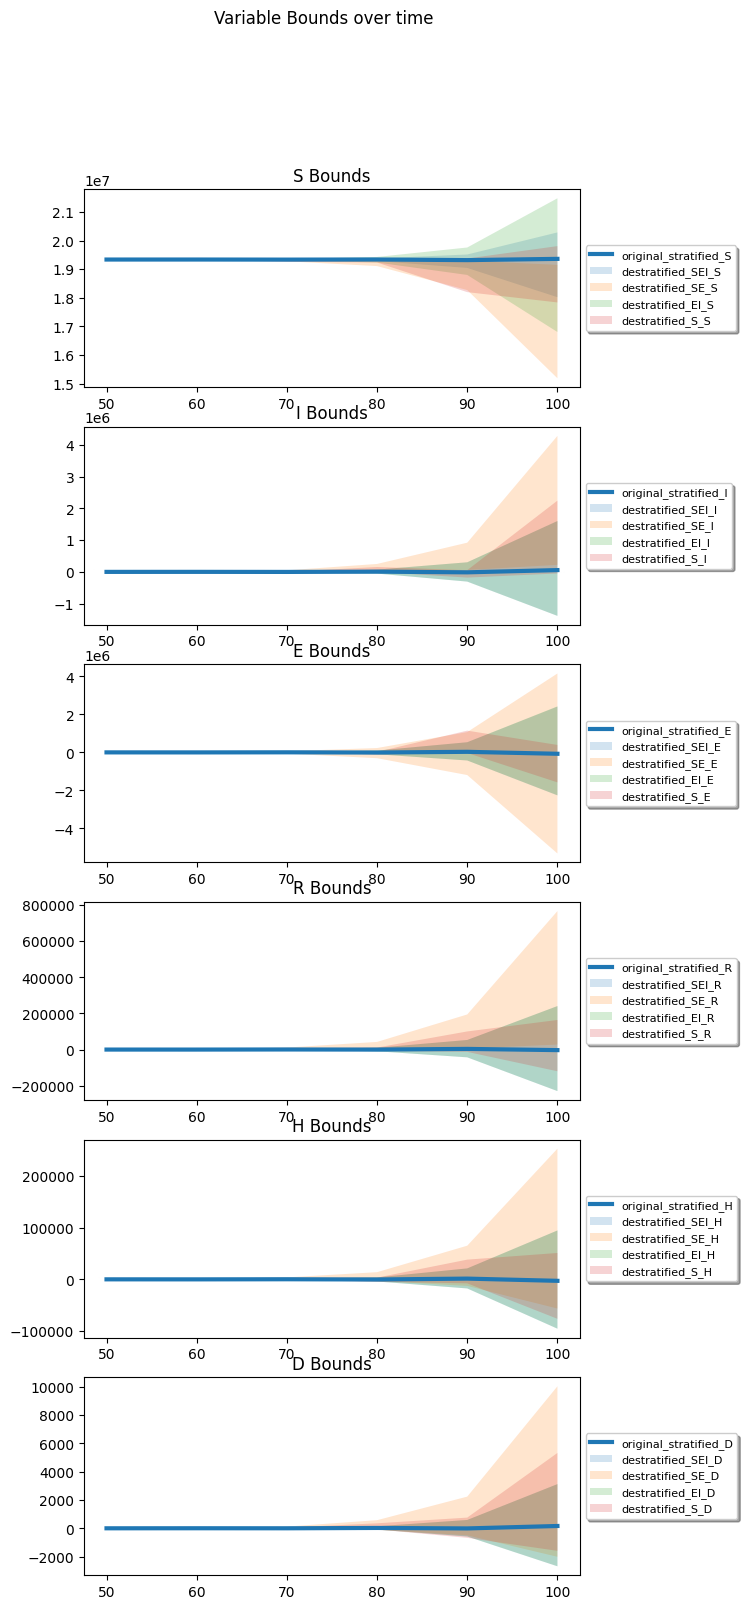

In [42]:


# point = results.points()[0]
# plot_bounds(point)
# points = {k:v.points()[0] for k,v in request_results.items()}
fig = None
axs = None

# zorders = {
#     "original_stratified": 10,
#     "destratified_SEI": 3,
#     "destratified_SE": 2,
#     "destratified_S": 9
# }
for name, result in request_results.items():
    # zorder = zorders[name]
    # vars = list(set([v.rsplit("_", 1)[0] for v in result.model._state_var_names()]))
    vars = result.model._state_var_names()
    point = result.points()[0]
    # print(name)
    # print(vars)
    # print(point.simulation.dataframe())
    
    fig, axs = plot_bounds(point,result, timespan=[50, 100], model=name, vars=vars, fig=fig, axs=axs, basevar_map=basevar_map,  alpha=0.2, linewidth=3, 
                        #    hatch=hatches[name], zorder=zorder
        )
    
# request_results

In [39]:
vars = ["S", "E", "I", "R", "D", "H"]
all_df = pd.DataFrame()
for name, result in request_results.items():
    df = results.dataframe([point])
    for var in vars:
        variants = list(set([variant.rsplit("_",1)[0] for variant in df.columns if var in variant and "compliant" in variant]))
        if len(variants) > 0:
            # sum compliant and noncompliant
            for variant in variants:
                for suffix in ["lb", "ub"]:
                    df[f"{var}_{suffix}"] = df[f"{variant}_{suffix}"]+df[f"{variant}_{suffix}"]
                    df = df.drop([f"{variant}_{suffix}", f"{variant}_{suffix}"], axis=1)
    df.columns = [f"{name}_{col}" for col in df.columns]
    all_df = pd.concat([all_df, df], axis=1)
all_df[[c for c in all_df.columns if "_E_lb" in c or "_E_ub" in c]]

,original_stratified_E_lb,original_stratified_E_ub,destratified_SEI_E_lb,destratified_SEI_E_ub,destratified_SE_E_lb,destratified_SE_E_ub,destratified_EI_E_lb,destratified_EI_E_ub,destratified_S_E_lb,destratified_S_E_ub
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,1.824000e+00,3.487999e+00,1.824000e+00,3.487999e+00,1.824000e+00,3.487999e+00,1.824000e+00,3.487999e+00,1.824000e+00,3.487999e+00
2,2.647999e+00,5.975999e+00,2.647999e+00,5.975999e+00,2.647999e+00,5.975999e+00,2.647999e+00,5.975999e+00,2.647999e+00,5.975999e+00
3,3.471999e+00,8.463998e+00,3.471999e+00,8.463998e+00,3.471999e+00,8.463998e+00,3.471999e+00,8.463998e+00,3.471999e+00,8.463998e+00
4,4.295999e+00,1.095200e+01,4.295999e+00,1.095200e+01,4.295999e+00,1.095200e+01,4.295999e+00,1.095200e+01,4.295999e+00,1.095200e+01
...,...,...,...,...,...,...,...,...,...,...
146,4.157384e+08,-9.338146e+10,4.157384e+08,-9.338146e+10,4.157384e+08,-9.338146e+10,4.157384e+08,-9.338146e+10,4.157384e+08,-9.338146e+10
147,3.792124e+08,-1.089595e+11,3.792124e+08,-1.089595e+11,3.792124e+08,-1.089595e+11,3.792124e+08,-1.089595e+11,3.792124e+08,-1.089595e+11
148,3.426864e+08,-1.245376e+11,3.426864e+08,-1.245376e+11,3.426864e+08,-1.245376e+11,3.426864e+08,-1.245376e+11,3.426864e+08,-1.245376e+11
149,3.061603e+08,-1.401157e+11,3.061603e+08,-1.401157e+11,3.061603e+08,-1.401157e+11,3.061603e+08,-1.401157e+11,3.061603e+08,-1.401157e+11
